# Lesson 3: Embeddings and Recurrent Neural Networks with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

In [26]:
import os
import sys
import logging
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
%matplotlib inline
%run plot_conf.py

In [27]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import (
    Variable,
)

from torch.nn import (
    init,
)

from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

### Embeddings

In the previous chapter, we learned how to represent text using one-hot encoded vectors. Wether it be at the word-level or char-level, we represent each token with a vector. Where the length of the vector was the number of unique tokens and was a zero vector except at once location (unique to the token). THis allowed us to represent our input text and use with our differentiable network's weights. This one-hot encoding method of representing text can quickly grow out of control as the size of our vocabulary increases. Not only do out input vector grow but the weights in our model will also grow accordingly.

$$ \text{I: } [1, 0, 0] \\ \text{am: } [0, 1, 0] \\ \text{good: } [0, 0, 1] $$

We also face another issue with representing the data as one-hot encoded vector. When we read text, the different tokens (words) have meaning to us and we can draw relationship between each of them. When we chose to represent the tokens with a one-hot encoded represetnation, all semantic and functional relationship is lost. An arbitrary index is used to represent each of our tokens and there is no way to draw meaning from the vectors. 

So, to solve both the issue of high dimensional representations and a meaningless representation, we can use embeddings to represent our text. Embeddings offer a low level representation that can capture the relationship between our tokens as well. 

Typically, embedding sizes range between 50-300 for each token which is largely empirically chosen. Let's start by looking at what a typical embedding matrix looks like. Suppose we have N tokens and we choose the emebdding size to be 300. Then our embedding matrix (weights) will be of size [N X 300], where N is the number of unique tokens. As with one-hot encoding, each token still has its own vector represtation but this time the number of columns is limited to 300 regardless of the number of unique tokens. Our embeddings can be randomly initialized but we can also initalize them. It is common to see random uniform initializations with range [−sqrt(3), sqrt(3)] or be uniform in the unit cube ([-1.0, 1.0]). 

$$ \text{embeddings: } [N X E] \\ \text{N: # of unique tokens} \\ \text{E: embedding size} $$

Now how do we represent our inputs using embeddings? For each token in our input, we will take the appropriate vector representation. For example, suppose we have word level emebddings (size 300) and we want to represent a five word long sentence with embeddings. We gather the embedding for each token to receive a input sentence representation that has dimensions [5 X 300]. Now we can go ahead and do additional evaluations on this vector for our task.

You may be wondering how random initializations can capture the relationship between our tokens and you are justified in thinking that because they do not, yet. Once we initalize our embeddings, we have several methods of manipulating the embeddings so that they are able to capture meaningful relationships. We will explore these various methods in detail in section 4.2, but the general premise is that we will use a feed forward network to build these meaningful embeddings in an unsupervised learning fashion. Once the embeddings are set, then we can use them for our specific task while keeping the emebddings frozen or still allow them to change. We can also choose to keep them randomly initialized and alter the embeddings while we train for our specific task. The later option usually leads to overfitting and does not capture true semantic relationships between the tokens. 

With PyTorch, it is very easy to create embeddings. 

In [28]:
class Model(nn.Module):
    """
    Model with random embeddings.
    """
    def __init__(self, input_size, hidden_size):
        """
        Initialize weights.
        """
        super(Model, self).__init__()
        
        # Embeddings
        self.embedding = nn.Embedding(
            num_embeddings=input_size,
            embedding_dim=hidden_size,
        )
        
        # Properly initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        self.embedding.weight.data.uniform_(
            -np.sqrt(3), np.sqrt(3))
        
    def forward(self, inputs):
        """
        Forward pass.
        """
        # Embed the inputs
        embedded_inputs = self.embedding(inputs)
        
        # Rest of forward pass
        ...
        
        return embedded_inputs

In [29]:
# Input: List of token ids for a sentence
X = Variable(torch.LongTensor([4, 2, 4, 1]))
print (X)

Variable containing:
 4
 2
 4
 1
[torch.LongTensor of size 4]



In [30]:
# Feed into the model to embed
model = Model(input_size=5, hidden_size=300)
embedded_inputs = model(X)
print (embedded_inputs)

Variable containing:
-1.6745 -1.0047 -1.5146  ...  -0.1317 -0.0313 -1.6230
-0.4109  0.0476  0.1311  ...  -1.2627 -0.9952  0.9369
-1.6745 -1.0047 -1.5146  ...  -0.1317 -0.0313 -1.6230
 0.0145  0.9278 -1.2476  ...   1.1719  0.6486  1.1977
[torch.FloatTensor of size 4x300]



We will explore initiailizing our emebddings with pre-learned vectors in the next section when we cover them in detail.

### Word2Vec Basics

How do we ensure that our embeddings are meaningful? As we discussed earlier, one option is to initialize them and then to have them be "unfrozen". What this means is that we allow the embeddings to change and are treated like regular weights in terms of parameter updates. This is one particular approach is often not used due to risk of overfitting. Since the embeddings will be changed in the direction that minimizes the objective function, they may not be generalizable embeddings for test time. They may not reflect the semantic relationships between the words and are tailored for the training task. An alternative to this approach is to learn the embeddings such that the similarity in the embedding space reflects the semantic simialrity between the words. 

One popular approach is the Word2Vec model proposed by Mikolov et. al. (https://arxiv.org/abs/1310.4546). The premise of the model was to embed words in $\mathbb{R}^d$ so that their inner product is maximized when words co-occur in similar contexts. A very large text corpora is used to do this in order to capture semantic meaning in the embeddings.

#### Skip-gram model

The model approach behind Word2vec is the skip-gram model. This model takes in a word and tries to predict the context words. The context words are considered to be the words to the right and left of the target word. The number of words we want to predict for either size depends on the window size. Let's look at an example to make this more concrete.

$$ \text{the sun was shining brightly today} $$

We want to create pairs of data points ($(context, target)$) from this input sentence which we will use in our skip-gram model to learn the proper embeddings. Let's assume that the window size is 1.

<img src="figures/ch04_skip_gram_data.jpg"></img>

With skip-gram, we want to predict each context word from the target word, so our dataset now looks like this:

$$\text{(sun, the), (sun, was), (was, sun), (was, shining), ... }$$

We feed in the target word and wan to receive the context word for the output. For our model, this means we want to input the emebedding for the target word and receive a result that decodes to the context word. You'll notice that particular target word maps to different context words. This is what we want because we are not trying to learn a one-to-one relationship but how each word relates to all the other words in our dataset. The target word's embedding gets updated with every run and as the performance of the model increases, our embeddings are able to capture more the semantic relationships. 

In [31]:
def skip_gram(sentences, window_size):
    """
    Create data based on
    skip-gram approach aka
    (predict context word
    from target word).
    """

    data = []
    for sentence in sentences:

        # For each index
        for i, index in enumerate(sentence):

            # Collect valid context indexes
            contexts = []
            for window in range(window_size):

                # left side
                if i-(window+1) >= 0:
                    contexts.append(sentence[i-(window+1)])
                # right side
                if i+(window+1) < len(sentence):
                    contexts.append(sentence[i+(window+1)])

            # Add to data
            for context in contexts:
                data.append((index, context))

    return data

The `skip_gram` function allows us to create training based on the ksip-gram approach. Using a window_size, we gather context words from the left and right of our target word and create pairs where we try to predict the context word from the target.

<img src="figures/ch04_skipgram.jpg"></img>

In [32]:
class MLP(nn.Module):
    """
    """
    def __init__(self, D_in, H):
        """
        Initialize weights.
        """
        super(MLP, self).__init__()

         # Embedding
        self.embedding = nn.Embedding(
            num_embeddings=D_in,
            embedding_dim=H,
            )
        self.fc2 = nn.Linear(H, D_in)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights.
        """
        self.embedding.weight.data.uniform_(-np.sqrt(3), np.sqrt(3))

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.embedding(x)
        z = self.fc2(z)
        return z

The training model is a simple `MLP` without any non-linearities. The objective is to use the context word's embedding to predict the target word. By repeatedly doing this using our training data, we will learn the semantic relationships between the words.

The trained some sample text (Wizard of Oz) using our simple skip_gram model and we are already able to map a few basic semantic relations. Below are a few similar words to the word `witch`. Similarity is based on the cosine distance between the embedding for `witch` and all the other words in our corpus.

```bash
Close to witch : ['wicked', 'evil', 'messenger', 'mouth', 'pot', 'heels', 'cooking', 'believe', 'pigs', 'mole']
```

### Using Pretrained Embeddings in PyTorch

```bash
bash fetch_embeddings.sh (in lesson3 directory)
```

In [33]:
from pytorch_code.glove.main import (
    get_embedding,
    load_embeddings,
    get_closest,
    pretty_print,
    get_analogy,
)

In [34]:
# Arguments
embedding_dir = os.path.join("embeddings/glove")
embedding_dim = 100 # 50, 100, 200, 300

In [35]:
logging.info("==> Loading Embeddings ...")
word_to_idx, embeddings = load_embeddings(
    embedding_dir=embedding_dir,
    embedding_dim=embedding_dim,
    )

2017-07-23 10:26:02,631 ==> Loading Embeddings ...
100%|██████████| 400000/400000 [00:37<00:00, 10570.10it/s]


#### Nearest neighbors

We will now use our pretrained embeddings to extract some of the relationships that were captured. We can use a simple distance metric to find out the nearest neighbors to a particular word.

In [36]:
word = input('Enter a word: ')
word_embedding = get_embedding(word, word_to_idx, embeddings)
pretty_print(get_closest(word_embedding, word_to_idx, embeddings, n=5))

Enter a word: gucci
[3.87] - burberry
[4.00] - prada
[4.01] - chanel
[4.02] - dior
[4.31] - fendi


#### Vector arithmetic
We can also do some vector arithmetic to see analogies as well. 


In [37]:
word1, word2, word3 = "man", "king", "woman"
pretty_print(get_analogy(word1, word2, word3, word_to_idx, embeddings))

[man : king :: woman : ?]
[4.08] - queen
[4.64] - monarch
[4.91] - throne
[4.92] - elizabeth
[4.98] - prince


We start by taking the embedding for `man` and subtract it from the embedding for `king`. This resulting vector is then added with the embedding for `woman`. We take this final representation and find the closest words to it. But why does this work? Since the embeddings are able to capture the relationship between the words, we can think of the vector we receive from `king`-`man` as the representation for trasnforming `man` to `king`. When we add this vector to `woman`, we apply the same transformation and we receive the expected 'queen' as one of the closest words. 

Now suppose we subtracted the embedding for `king` from `man`, which means the representation now holds the information to transform a king to a man. You can think of `man` as a younger version of `king` and also a more general term. When we add this difference to `woman`, we receive words like `girl` and `person`. Both of which are in accordance with our younger and more general expectations. 

In [38]:
word1, word2, word3 = "king", "man", "woman"
pretty_print(get_analogy(word1, word2, word3, word_to_idx, embeddings))

[king : man :: woman : ?]
[7.17] - girl
[7.64] - person
[7.72] - victim
[7.78] - boy
[7.80] - teenager


Try more examples!

In [21]:
word1, word2, word3 = input("Enter three words to fill ____ : ____ :: _____ ").split()
pretty_print(get_analogy(word1, word2, word3, word_to_idx, embeddings))

Enter three words to fill ____ : ____ :: _____ banana yellow grapes
[banana : yellow :: grapes : ?]
[6.64] - purple
[6.77] - red
[6.99] - colors
[7.01] - bright
[7.15] - daffodils


#### Visualize embeddings

We can also visualize the embeddings to see clusters, etc. We will use [t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) to visusalize our high dimensional embeddings on a 2D plane. The method allows us to take high-dimensional inputs and gives us a lower-dimensional representation. In our case, we are converting our high-dimensional embeddings to two dimensions so we can visualize them on a 2D plane. t-SNE applies non-linear transformation to regions of the initial input while maintaining the complex relationships between our points as much as possible. The algorithm involves several complicated hyperparameters such as perplexity, etc. but we do not need to address paritculars for our visualization purpose. 

In [39]:
from sklearn.manifold import TSNE

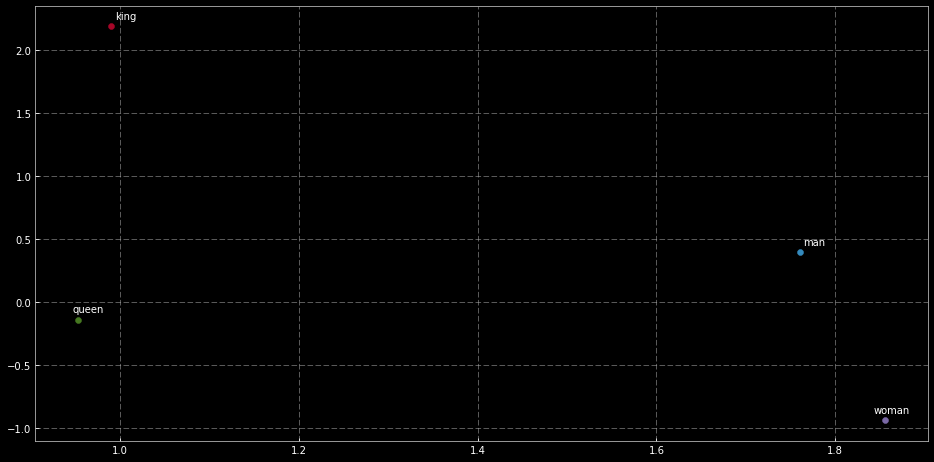

In [40]:
# Retrieve embeddings for words
words = ["man", "king", "woman", "queen"]
my_embeddings = np.array([
    get_embedding(word, word_to_idx, embeddings).numpy() \
    for word in words])

# Use TSNE model to reduce dimensionality
model = TSNE(n_components=2, random_state=0)
points = model.fit_transform(my_embeddings) 

# Visualize
for i, word in enumerate(words):
    x, y = points[i, 0]*1e4, points[i, 1]*1e4
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(25, 5),
        textcoords='offset points', ha='right', va='bottom')

### Recurrent Neural Networks

http://pytorch.org/docs/master/nn.html#recurrent-layers

In [25]:
class Encoder(nn.Module):
    """
    """
    def __init__(self, num_unique_words, embedding_dim,
        num_hidden_units, num_layers, dropout_p, embeddings=None):
        """
        Initialize weights.
        """
        super(Encoder, self).__init__()
        self.num_hidden_units = num_hidden_units
        self.num_layers = num_layers

        # Embeddings
        self.embeddings = embeddings
        self.word_embeddings = nn.Embedding(
            num_embeddings=num_unique_words,
            embedding_dim=embedding_dim,
            )

        # RNN
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=num_hidden_units,
            num_layers=num_layers,
            bidirectional=False,
            batch_first=True,
            dropout=dropout_p,
            )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights.
        """

        # Freeze GloVe embeddings
        self.word_embeddings.weight.data = self.embeddings
        self.word_embeddings.weight.requires_grad=False

    def init_hidden(self, batch_size):
        """
        Initialize hidden
        states for RNN.
        """

        self.batch_size = batch_size
        states = Variable(
            torch.zeros(
                self.num_layers, self.batch_size, self.num_hidden_units))

    def forward(self, inputs, indexes, states):
        """
        Forward pass.
        """

        # Embed the inputs
        embedded_inputs = self.word_embeddings(inputs)

        # Feed into RNN
        rnn_outputs, last_state = self.gru(embedded_inputs, states)

        # Extract relevant state
        last_relevant_state = torch.gather(
            rnn_outputs,
            dim=1,
            index=indexes,
            )

        return last_relevant_state.view(self.batch_size, self.num_hidden_units)

class Decoder(nn.Module):
    """
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialize weights.
        """
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(num_hidden_units, num_hidden_units)
        self.dropout1 = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.dropout2 = nn.Dropout(dropout_p)
        self.out = nn.Linear(num_hidden_units, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights.
        """
        init.xavier_uniform(
            self.fc1.weight,
            gain=calculate_gain('relu'),
            )
        init.xavier_uniform(
            self.fc2.weight,
            gain=calculate_gain('relu'),
            )

    def forward(self, encoder_output):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(encoder_output))
        z = self.dropout1(z)
        z = F.relu(self.fc2(z))
        z = self.dropout2(z)
        output = self.out(z)
        return output

### END

**Note**: Future posts will cover specific example use cases with RNNs including attention mechanisms, tree based RNN structures, etc.